# Experimentando retificação superior e classificação

Ao invés de binarizar completamente a imagem, apenas os píxeis de valor abaixo do limiar de otsu são convertidos para 0.

## Importando bibliotecas

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from zipfile import ZipFile
from skimage import io
from skimage.filters import threshold_otsu
from skimage.feature import local_binary_pattern

# Parâmetros do LBP
METHOD = 'nri_uniform'
RADIUS = 1
N_POINTS = 8

TARGET_NAMES = {'nao_faixa': 0,
                'faixa_frente': 1,
                'faixa_diagonal_direita': 2,
                'faixa_diagonal_esquerda': 3}

## Processando imagens

In [2]:
path_dict = {name: [] for name in TARGET_NAMES}

with ZipFile('./texturas.zip') as zip_file:
  for path in zip_file.namelist():
    # a pasta de cada amostra é o segundo elemento do split
    folder = path.split('/')[1]
    # Separando amostras por classe
    if folder in TARGET_NAMES:
      path_dict[folder].append(f'./texturas.zip/{path}')

# Mostrando quantidade de amostras por classe
for target in path_dict:
  print(f'{target}: {len(path_dict[target])} amostras')

amostra = []
limiares = {name:[] for name in TARGET_NAMES}

for target_name in TARGET_NAMES:
    for path in path_dict[target_name]:
        img = io.imread(path, as_gray=True)
        limiar = threshold_otsu(img)
        limiares[target_name].append(limiar)

        # Alterando píxeis que sejam de valor maiores ou igual ao limiar
        img[img < limiar] = 0
        
        lbp = local_binary_pattern(image=img, P=N_POINTS, R=RADIUS, method=METHOD).flatten()
        hist = pd.Series(lbp).value_counts().sort_index()
        arr = np.zeros(59)
        for i in hist.index:
            arr[int(i)] = hist[i]

        df = pd.DataFrame(data=[arr])
        df['target'] = TARGET_NAMES[target_name]
        amostra.append(df)

data = pd.concat(amostra, ignore_index=True)
data.to_csv('./csvs/otsu_inf-lbp_faixas.csv')
data

nao_faixa: 750 amostras
faixa_frente: 250 amostras
faixa_diagonal_direita: 250 amostras
faixa_diagonal_esquerda: 250 amostras


,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,target
0,16888.0,10514.0,716.0,4427.0,708.0,10567.0,705.0,4380.0,742.0,3659.0,...,4971.0,7593.0,14034.0,6267.0,5013.0,7602.0,14363.0,430990.0,60062.0,0
1,996.0,682.0,37.0,353.0,38.0,685.0,46.0,405.0,34.0,197.0,...,406.0,936.0,1818.0,1186.0,360.0,989.0,1878.0,865554.0,5008.0,0
2,13661.0,9977.0,438.0,4144.0,391.0,9735.0,369.0,3926.0,480.0,3302.0,...,3871.0,5977.0,10948.0,5267.0,3770.0,5776.0,10789.0,501196.0,51323.0,0
3,7022.0,4387.0,265.0,1983.0,224.0,4483.0,268.0,2046.0,245.0,1569.0,...,2171.0,3093.0,5618.0,2969.0,2065.0,2840.0,5592.0,718326.0,25120.0,0
4,3862.0,2777.0,88.0,1618.0,110.0,2971.0,117.0,1921.0,114.0,546.0,...,1364.0,1777.0,2243.0,1799.0,1195.0,1769.0,2431.0,763312.0,16723.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,23084.0,16425.0,696.0,6268.0,593.0,16735.0,767.0,6971.0,675.0,5364.0,...,5011.0,5579.0,15334.0,5168.0,4780.0,4998.0,15257.0,305369.0,75101.0,3
1496,19494.0,15061.0,542.0,4618.0,537.0,14841.0,557.0,5017.0,591.0,4244.0,...,3910.0,4781.0,16077.0,4854.0,3620.0,4379.0,15938.0,411270.0,63150.0,3
1497,18649.0,13243.0,396.0,5860.0,548.0,13185.0,486.0,6453.0,637.0,4616.0,...,4815.0,5351.0,13290.0,5082.0,4287.0,4846.0,13227.0,386417.0,64814.0,3
1498,25162.0,17825.0,819.0,5223.0,972.0,17744.0,967.0,5412.0,1057.0,7147.0,...,5101.0,5333.0,19157.0,5046.0,5094.0,5151.0,19506.0,277346.0,77213.0,3


In [3]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,
                             classification_report,
                             confusion_matrix,
                             f1_score,
                             plot_confusion_matrix)

## Realizando 30 rodadas de classificação

Rodada 0	-	Seed 693
                         precision    recall  f1-score   support

              nao_faixa       0.95      0.98      0.96       224
           faixa_frente       0.71      0.77      0.74        74
 faixa_diagonal_direita       0.81      0.72      0.76        78
faixa_diagonal_esquerda       0.96      0.91      0.93        74

               accuracy                           0.89       450
              macro avg       0.86      0.84      0.85       450
           weighted avg       0.89      0.89      0.89       450



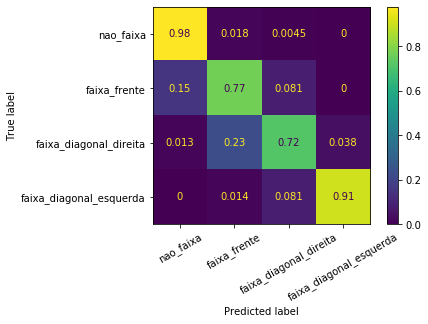

Rodada 1	-	Seed 5098
                         precision    recall  f1-score   support

              nao_faixa       0.94      0.98      0.96       229
           faixa_frente       0.73      0.73      0.73        75
 faixa_diagonal_direita       0.75      0.67      0.71        69
faixa_diagonal_esquerda       0.93      0.91      0.92        77

               accuracy                           0.88       450
              macro avg       0.84      0.82      0.83       450
           weighted avg       0.87      0.88      0.88       450



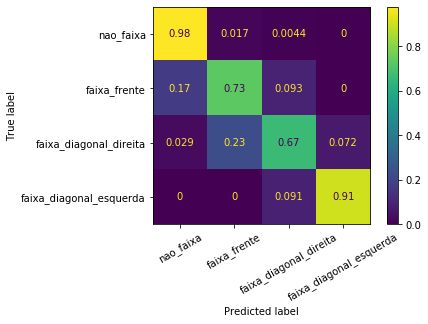

Rodada 2	-	Seed 424
                         precision    recall  f1-score   support

              nao_faixa       0.93      0.96      0.94       224
           faixa_frente       0.64      0.74      0.69        77
 faixa_diagonal_direita       0.67      0.67      0.67        73
faixa_diagonal_esquerda       0.91      0.67      0.77        76

               accuracy                           0.83       450
              macro avg       0.79      0.76      0.77       450
           weighted avg       0.83      0.83      0.83       450



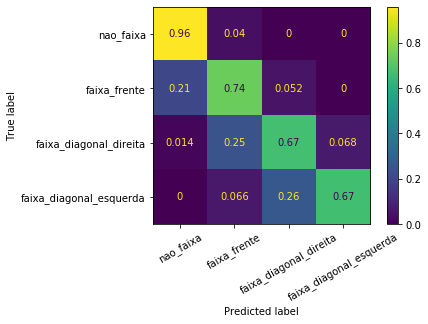

Rodada 3	-	Seed 2175
                         precision    recall  f1-score   support

              nao_faixa       0.92      0.98      0.95       232
           faixa_frente       0.79      0.67      0.72        82
 faixa_diagonal_direita       0.63      0.76      0.69        66
faixa_diagonal_esquerda       0.96      0.73      0.83        70

               accuracy                           0.85       450
              macro avg       0.82      0.78      0.80       450
           weighted avg       0.86      0.85      0.85       450



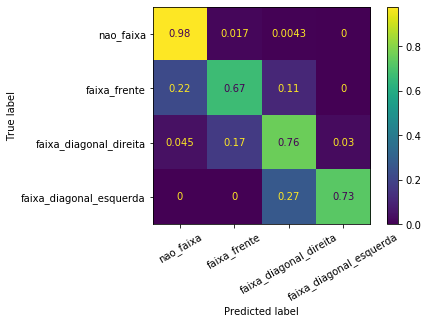

Rodada 4	-	Seed 1
                         precision    recall  f1-score   support

              nao_faixa       0.94      1.00      0.97       229
           faixa_frente       0.73      0.74      0.73        73
 faixa_diagonal_direita       0.89      0.67      0.76        81
faixa_diagonal_esquerda       0.90      0.97      0.94        67

               accuracy                           0.89       450
              macro avg       0.86      0.84      0.85       450
           weighted avg       0.89      0.89      0.89       450



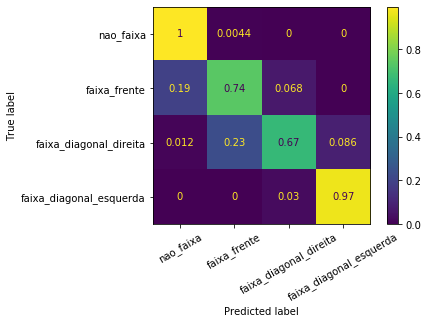

Rodada 5	-	Seed 3924
                         precision    recall  f1-score   support

              nao_faixa       0.93      0.96      0.95       244
           faixa_frente       0.72      0.65      0.68        71
 faixa_diagonal_direita       0.78      0.74      0.76        66
faixa_diagonal_esquerda       0.90      0.94      0.92        69

               accuracy                           0.88       450
              macro avg       0.83      0.82      0.83       450
           weighted avg       0.87      0.88      0.87       450



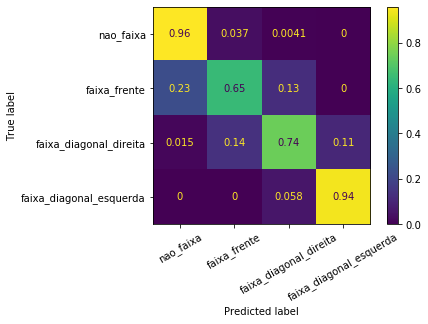

Rodada 6	-	Seed 5516
                         precision    recall  f1-score   support

              nao_faixa       0.95      0.96      0.95       231
           faixa_frente       0.69      0.81      0.74        72
 faixa_diagonal_direita       0.88      0.61      0.72        83
faixa_diagonal_esquerda       0.82      0.95      0.88        64

               accuracy                           0.87       450
              macro avg       0.84      0.83      0.83       450
           weighted avg       0.88      0.87      0.87       450



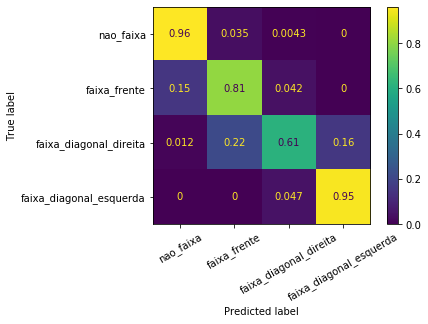

Rodada 7	-	Seed 2957
                         precision    recall  f1-score   support

              nao_faixa       0.94      0.98      0.96       222
           faixa_frente       0.73      0.77      0.75        73
 faixa_diagonal_direita       0.62      0.71      0.66        72
faixa_diagonal_esquerda       0.95      0.69      0.80        83

               accuracy                           0.85       450
              macro avg       0.81      0.79      0.79       450
           weighted avg       0.86      0.85      0.85       450



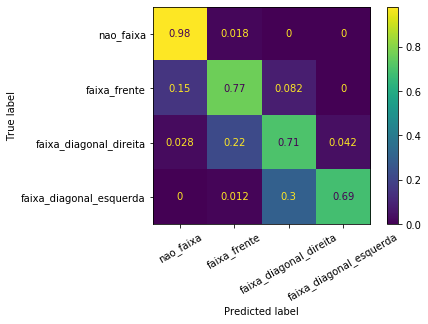

Rodada 8	-	Seed 2825
                         precision    recall  f1-score   support

              nao_faixa       0.95      0.98      0.97       219
           faixa_frente       0.77      0.77      0.77        78
 faixa_diagonal_direita       0.82      0.65      0.73        78
faixa_diagonal_esquerda       0.85      0.95      0.89        75

               accuracy                           0.88       450
              macro avg       0.85      0.84      0.84       450
           weighted avg       0.88      0.88      0.88       450



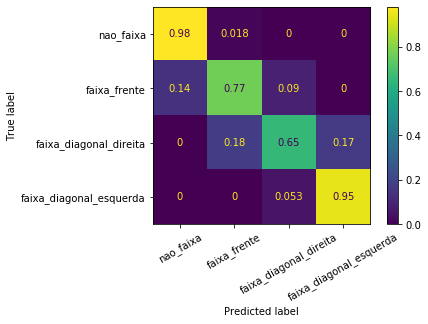

Rodada 9	-	Seed 1017
                         precision    recall  f1-score   support

              nao_faixa       0.90      0.97      0.93       224
           faixa_frente       0.64      0.62      0.63        73
 faixa_diagonal_direita       0.81      0.61      0.69        76
faixa_diagonal_esquerda       0.93      0.96      0.94        77

               accuracy                           0.85       450
              macro avg       0.82      0.79      0.80       450
           weighted avg       0.85      0.85      0.84       450



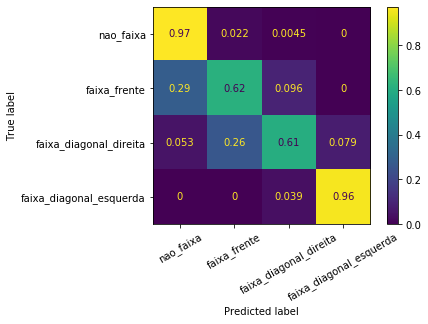

Rodada 10	-	Seed 7633
                         precision    recall  f1-score   support

              nao_faixa       0.93      0.98      0.95       232
           faixa_frente       0.75      0.71      0.73        75
 faixa_diagonal_direita       0.64      0.73      0.68        66
faixa_diagonal_esquerda       0.97      0.73      0.83        77

               accuracy                           0.86       450
              macro avg       0.82      0.79      0.80       450
           weighted avg       0.86      0.86      0.85       450



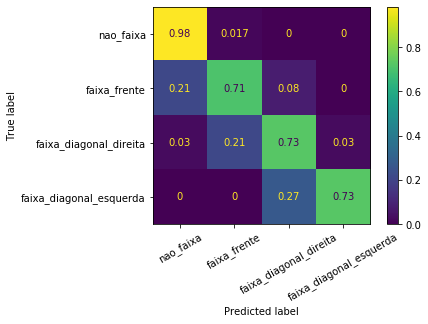

Rodada 11	-	Seed 4119
                         precision    recall  f1-score   support

              nao_faixa       0.95      0.98      0.96       228
           faixa_frente       0.70      0.74      0.72        57
 faixa_diagonal_direita       0.78      0.69      0.73        86
faixa_diagonal_esquerda       0.87      0.85      0.86        79

               accuracy                           0.87       450
              macro avg       0.82      0.81      0.82       450
           weighted avg       0.87      0.87      0.87       450



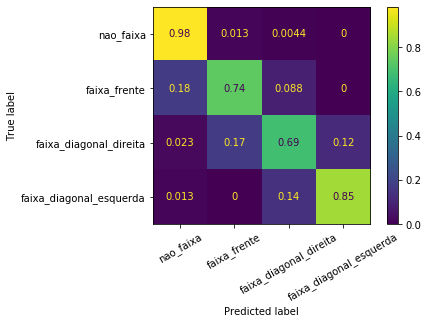

Rodada 12	-	Seed 1132
                         precision    recall  f1-score   support

              nao_faixa       0.93      1.00      0.96       205
           faixa_frente       0.63      0.74      0.68        70
 faixa_diagonal_direita       0.80      0.58      0.68        91
faixa_diagonal_esquerda       0.90      0.89      0.90        84

               accuracy                           0.85       450
              macro avg       0.82      0.80      0.80       450
           weighted avg       0.85      0.85      0.85       450



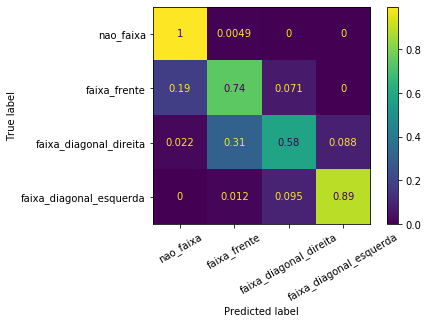

Rodada 13	-	Seed 5997
                         precision    recall  f1-score   support

              nao_faixa       0.91      0.96      0.94       223
           faixa_frente       0.57      0.69      0.62        67
 faixa_diagonal_direita       0.81      0.67      0.73        86
faixa_diagonal_esquerda       0.95      0.80      0.87        74

               accuracy                           0.84       450
              macro avg       0.81      0.78      0.79       450
           weighted avg       0.85      0.84      0.84       450



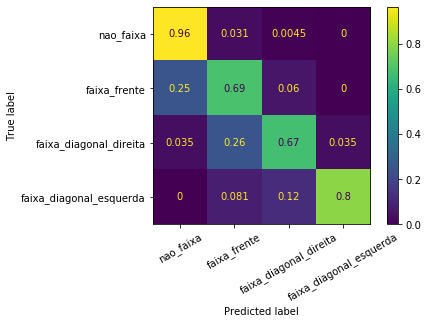

Rodada 14	-	Seed 3707
                         precision    recall  f1-score   support

              nao_faixa       0.93      0.97      0.95       221
           faixa_frente       0.73      0.73      0.73        79
 faixa_diagonal_direita       0.74      0.69      0.71        74
faixa_diagonal_esquerda       0.92      0.86      0.88        76

               accuracy                           0.86       450
              macro avg       0.83      0.81      0.82       450
           weighted avg       0.86      0.86      0.86       450



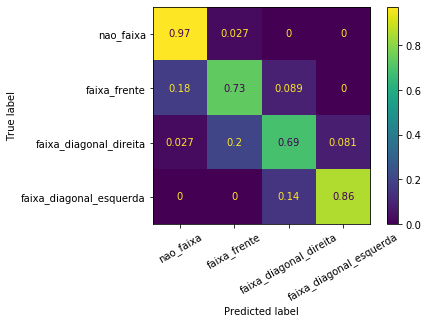

Rodada 15	-	Seed 5494
                         precision    recall  f1-score   support

              nao_faixa       0.97      0.98      0.98       238
           faixa_frente       0.59      0.76      0.66        66
 faixa_diagonal_direita       0.72      0.64      0.68        75
faixa_diagonal_esquerda       0.95      0.76      0.84        71

               accuracy                           0.86       450
              macro avg       0.81      0.79      0.79       450
           weighted avg       0.87      0.86      0.86       450



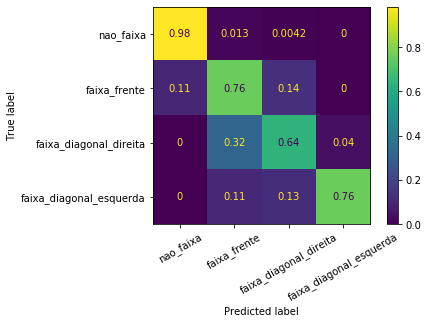

Rodada 16	-	Seed 4052
                         precision    recall  f1-score   support

              nao_faixa       0.94      0.97      0.95       216
           faixa_frente       0.65      0.79      0.71        76
 faixa_diagonal_direita       0.94      0.52      0.67        86
faixa_diagonal_esquerda       0.84      0.99      0.90        72

               accuracy                           0.86       450
              macro avg       0.84      0.82      0.81       450
           weighted avg       0.87      0.86      0.85       450



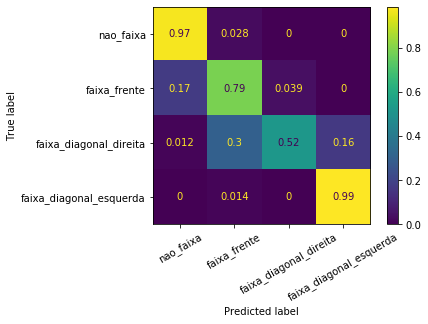

Rodada 17	-	Seed 4358
                         precision    recall  f1-score   support

              nao_faixa       0.91      0.97      0.94       222
           faixa_frente       0.60      0.64      0.62        73
 faixa_diagonal_direita       0.84      0.61      0.71        85
faixa_diagonal_esquerda       0.89      0.96      0.92        70

               accuracy                           0.85       450
              macro avg       0.81      0.80      0.80       450
           weighted avg       0.85      0.85      0.84       450



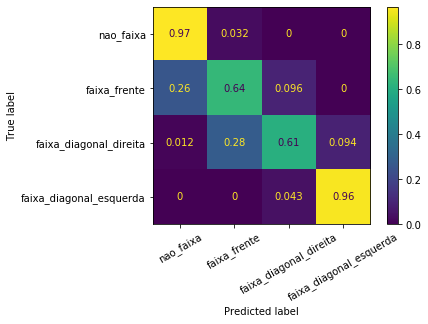

Rodada 18	-	Seed 6323
                         precision    recall  f1-score   support

              nao_faixa       0.93      0.98      0.95       201
           faixa_frente       0.77      0.73      0.75        82
 faixa_diagonal_direita       0.62      0.74      0.67        77
faixa_diagonal_esquerda       0.94      0.71      0.81        90

               accuracy                           0.84       450
              macro avg       0.81      0.79      0.80       450
           weighted avg       0.85      0.84      0.84       450



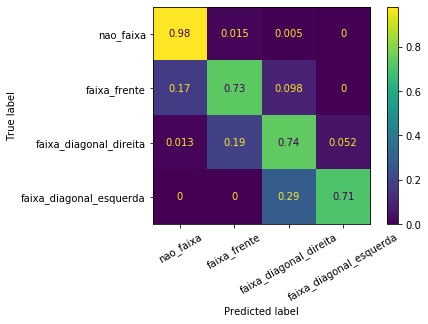

Rodada 19	-	Seed 3334
                         precision    recall  f1-score   support

              nao_faixa       0.95      0.96      0.95       232
           faixa_frente       0.79      0.79      0.79        70
 faixa_diagonal_direita       0.55      0.84      0.67        57
faixa_diagonal_esquerda       0.97      0.64      0.77        91

               accuracy                           0.85       450
              macro avg       0.81      0.81      0.79       450
           weighted avg       0.88      0.85      0.85       450



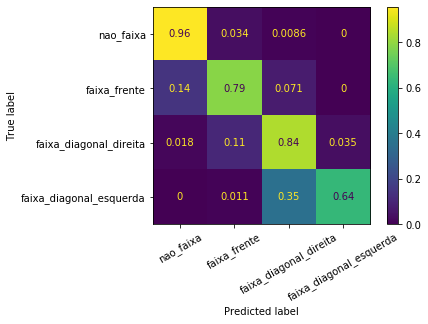

Rodada 20	-	Seed 2118
                         precision    recall  f1-score   support

              nao_faixa       0.91      0.97      0.94       227
           faixa_frente       0.74      0.65      0.69        78
 faixa_diagonal_direita       0.83      0.67      0.74        72
faixa_diagonal_esquerda       0.89      0.99      0.94        73

               accuracy                           0.87       450
              macro avg       0.84      0.82      0.83       450
           weighted avg       0.87      0.87      0.87       450



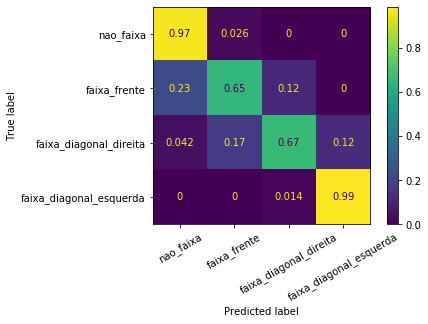

Rodada 21	-	Seed 5473
                         precision    recall  f1-score   support

              nao_faixa       0.93      0.96      0.95       213
           faixa_frente       0.71      0.73      0.72        84
 faixa_diagonal_direita       0.77      0.60      0.68        78
faixa_diagonal_esquerda       0.86      0.95      0.90        75

               accuracy                           0.85       450
              macro avg       0.82      0.81      0.81       450
           weighted avg       0.85      0.85      0.85       450



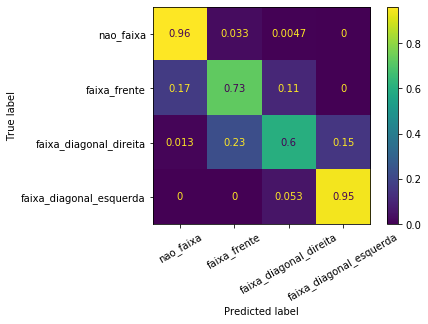

Rodada 22	-	Seed 696
                         precision    recall  f1-score   support

              nao_faixa       0.91      0.96      0.93       214
           faixa_frente       0.67      0.71      0.69        79
 faixa_diagonal_direita       0.73      0.70      0.72        81
faixa_diagonal_esquerda       0.95      0.76      0.85        76

               accuracy                           0.84       450
              macro avg       0.81      0.78      0.80       450
           weighted avg       0.84      0.84      0.84       450



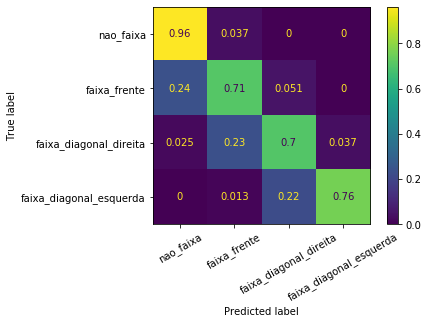

Rodada 23	-	Seed 279
                         precision    recall  f1-score   support

              nao_faixa       0.95      0.97      0.96       248
           faixa_frente       0.80      0.74      0.77        76
 faixa_diagonal_direita       0.71      0.83      0.77        66
faixa_diagonal_esquerda       0.96      0.78      0.86        60

               accuracy                           0.89       450
              macro avg       0.86      0.83      0.84       450
           weighted avg       0.89      0.89      0.89       450



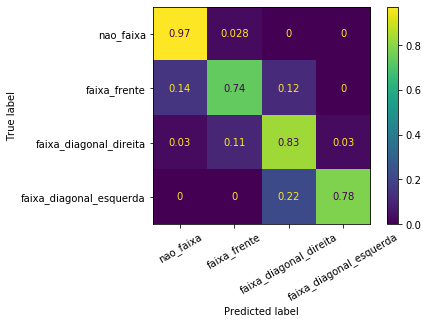

Rodada 24	-	Seed 1174
                         precision    recall  f1-score   support

              nao_faixa       0.94      0.97      0.95       239
           faixa_frente       0.71      0.71      0.71        80
 faixa_diagonal_direita       0.84      0.72      0.77        71
faixa_diagonal_esquerda       0.94      0.97      0.95        60

               accuracy                           0.88       450
              macro avg       0.85      0.84      0.85       450
           weighted avg       0.88      0.88      0.88       450



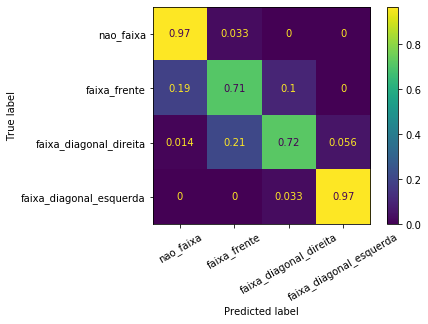

Rodada 25	-	Seed 366
                         precision    recall  f1-score   support

              nao_faixa       0.93      0.99      0.96       214
           faixa_frente       0.69      0.74      0.72        82
 faixa_diagonal_direita       0.83      0.59      0.69        81
faixa_diagonal_esquerda       0.91      0.97      0.94        73

               accuracy                           0.87       450
              macro avg       0.84      0.82      0.83       450
           weighted avg       0.87      0.87      0.86       450



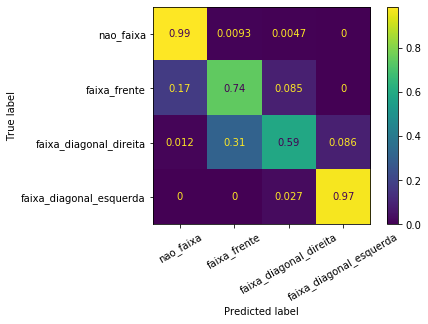

Rodada 26	-	Seed 3859
                         precision    recall  f1-score   support

              nao_faixa       0.92      0.96      0.94       218
           faixa_frente       0.56      0.74      0.64        69
 faixa_diagonal_direita       0.80      0.66      0.72        87
faixa_diagonal_esquerda       0.95      0.74      0.83        76

               accuracy                           0.83       450
              macro avg       0.81      0.77      0.78       450
           weighted avg       0.85      0.83      0.83       450



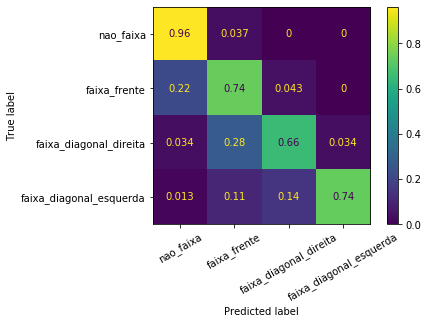

Rodada 27	-	Seed 2541
                         precision    recall  f1-score   support

              nao_faixa       0.93      0.98      0.95       213
           faixa_frente       0.65      0.77      0.71        71
 faixa_diagonal_direita       0.61      0.64      0.62        78
faixa_diagonal_esquerda       0.93      0.62      0.75        88

               accuracy                           0.82       450
              macro avg       0.78      0.76      0.76       450
           weighted avg       0.83      0.82      0.82       450



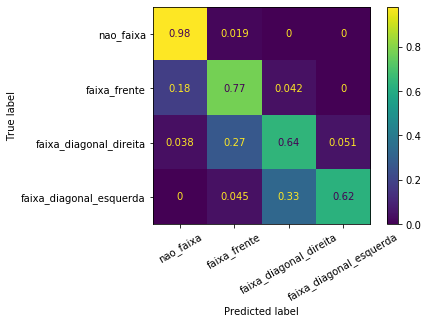

Rodada 28	-	Seed 7375
                         precision    recall  f1-score   support

              nao_faixa       0.94      0.97      0.96       234
           faixa_frente       0.73      0.69      0.71        74
 faixa_diagonal_direita       0.62      0.75      0.68        64
faixa_diagonal_esquerda       0.95      0.73      0.83        78

               accuracy                           0.85       450
              macro avg       0.81      0.79      0.79       450
           weighted avg       0.86      0.85      0.85       450



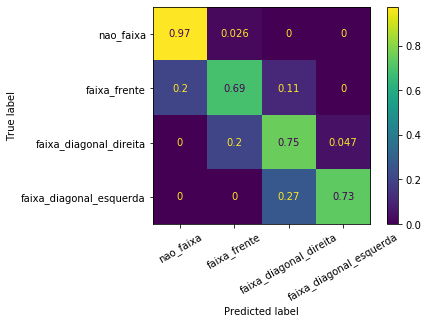

Rodada 29	-	Seed 285
                         precision    recall  f1-score   support

              nao_faixa       0.93      0.97      0.95       216
           faixa_frente       0.77      0.72      0.74        81
 faixa_diagonal_direita       0.69      0.73      0.71        67
faixa_diagonal_esquerda       0.94      0.85      0.89        86

               accuracy                           0.87       450
              macro avg       0.83      0.82      0.82       450
           weighted avg       0.87      0.87      0.87       450



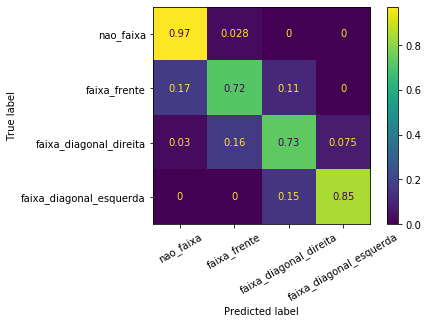

In [4]:
df = pd.read_csv('./csvs/otsu_inf-lbp_faixas.csv')
y = df.pop('target').values
X = df.values

# Gerando 30 sementes "aleatórias" dentro do intervalo [0, 8000)
seed_arr = np.random.randint(8000, size=30)

acc_e_f1_por_rodada = []
confu_matrices = []

for rodada, seed in enumerate(seed_arr):
  # separando dados
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

  clf = make_pipeline(StandardScaler(), SVC()).fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  
  # Adicionando resultados à respectiva lista
  acc_e_f1_por_rodada.append(
    [accuracy_score(y_test, y_pred)]
    + list(f1_score(y_test, y_pred, average=None)))

  confu_matrices.append(
    confusion_matrix(y_test, y_pred, normalize='true'))

  print(f'Rodada {rodada}\t-\tSeed {seed}')
  print(
    classification_report(
      y_true=y_test,
      y_pred=y_pred,
      target_names=TARGET_NAMES))

  plot_confusion_matrix(
    estimator=clf,
    X=X_test,
    y_true=y_test,
    display_labels=TARGET_NAMES,
    xticks_rotation=30,
    normalize='true')
  
  plt.show()

## Métricas do experimento

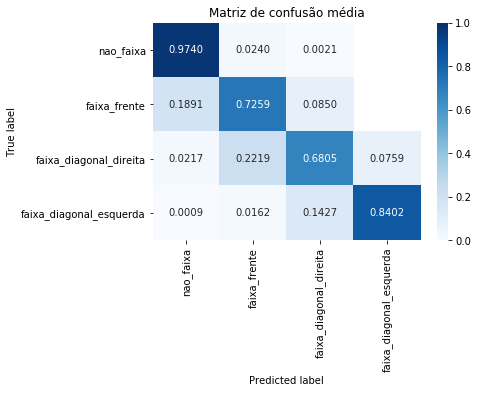

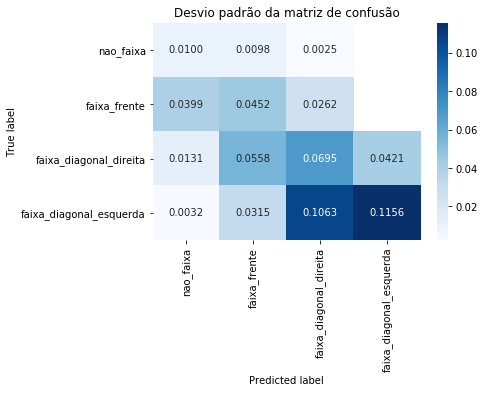

In [5]:
confusion_matrix_mean = np.mean(confu_matrices, axis=0)
confusion_matrix_std = np.std(confu_matrices, axis=0)

sns.heatmap(
    data=confusion_matrix_mean,
    cmap='Blues',
    vmin=0,
    vmax=1,
    annot=True,
    fmt='.4f',
    mask=confusion_matrix_mean == 0,
    xticklabels=TARGET_NAMES,
    yticklabels=TARGET_NAMES
    ).set(
        title='Matriz de confusão média',
        xlabel='Predicted label',
        ylabel='True label')

plt.show()

sns.heatmap(
    data=confusion_matrix_std,
    cmap='Blues',
    annot=True,
    fmt='.4f',
    mask=confusion_matrix_std == 0,
    xticklabels=TARGET_NAMES,
    yticklabels=TARGET_NAMES
    ).set(
        title='Desvio padrão da matriz de confusão',
        xlabel='Predicted label',
        ylabel='True label')

None

        Acurácia  f1-nao_faixa  f1-faixa_frente  f1-faixa_diagonal_direita  \
count  30.000000     30.000000        30.000000                  30.000000   
mean    0.859037      0.952742         0.709953                   0.706229   
std     0.018535      0.010267         0.042870                   0.036732   
min     0.820000      0.933619         0.621622                   0.625000   
25%     0.849444      0.945549         0.686839                   0.676107   
50%     0.856667      0.954167         0.717647                   0.707588   
75%     0.871111      0.959892         0.738868                   0.728527   
max     0.891111      0.977035         0.785714                   0.772727   

       f1-faixa_diagonal_esquerda  
count                   30.000000  
mean                     0.871524  
std                      0.056640  
min                      0.748299  
25%                      0.829630  
50%                      0.884206  
75%                      0.921753  
max      

Acurácia,f1-nao_faixa,f1-faixa_frente,f1-faixa_diagonal_direita,f1-faixa_diagonal_esquerda
0.886667,0.962637,0.740260,0.761905,0.930556
0.877778,0.957265,0.733333,0.707692,0.921053
0.826667,0.942982,0.686747,0.671233,0.772727
0.851111,0.945833,0.723684,0.689655,0.829268
0.891111,0.966102,0.734694,0.760563,0.935252
0.875556,0.945455,0.681481,0.759690,0.921986
0.871111,0.954839,0.743590,0.723404,0.884058
0.848889,0.962472,0.746667,0.662338,0.797203
0.882222,0.966292,0.769231,0.728571,0.893082
0.851111,0.933619,0.629371,0.691729,0.942675


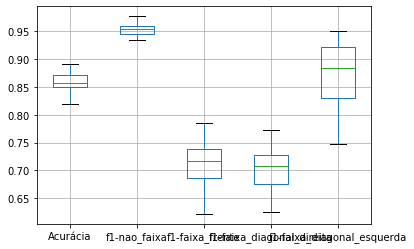

In [7]:
acc_df = pd.DataFrame(
  data=acc_e_f1_por_rodada,
  columns=['Acurácia'] + [f'f1-{name}' for name in TARGET_NAMES])

print(acc_df.describe())

acc_df.boxplot()

acc_df.style.hide_index().background_gradient(cmap='Blues')